In [1]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline  

import torch
import torch.nn as nn


import torch.optim as optim

import sys
sys.path.insert(0, '../libraries/')

import mnist_data_lib
import mnist_vae_lib
import common_utils

import torchvision.datasets as dset
import torchvision.transforms as transforms
import torch.nn.functional as F

from torch.distributions import Categorical

import timeit

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


# Load data

In [2]:
train_set_labeled, train_set_unlabeled, test_set = \
    mnist_data_lib.get_mnist_dataset_semisupervised(propn_sample=0.001)

In [3]:
print('num_train_labeled: ', train_set_labeled.num_images)
print('num_train_unlabled: ', train_set_unlabeled.num_images)

print('num_test: ', test_set.num_images)

num_train_labeled:  6
num_train_unlabled:  54
num_test:  10


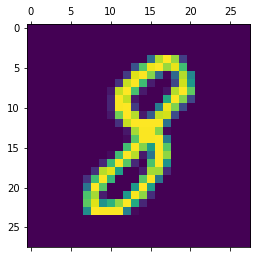

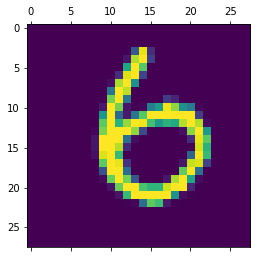

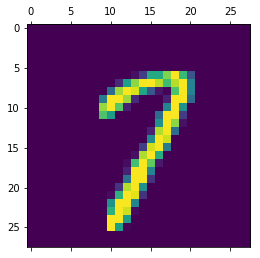

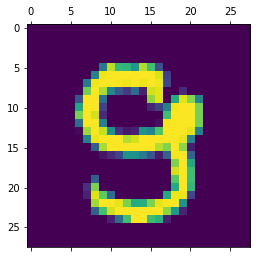

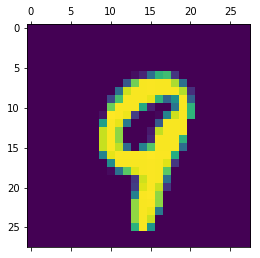

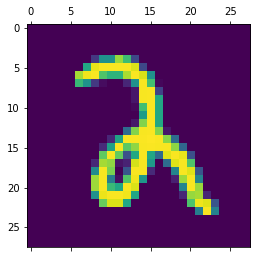

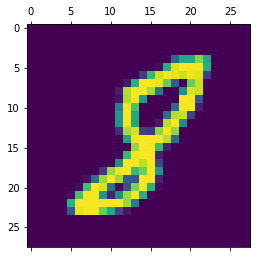

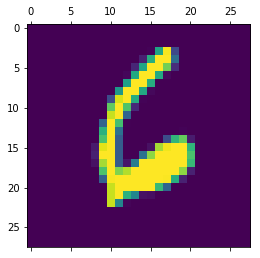

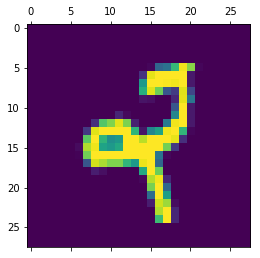

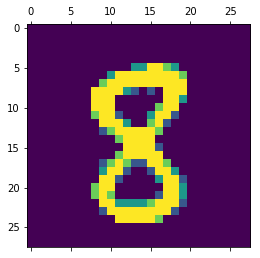

In [4]:
for i in range(10): 
    plt.matshow(train_set_unlabeled[i]['image'].squeeze())
    assert np.all(train_set_unlabeled[i]['image'].detach().numpy() <= 1)
    assert np.all(train_set_unlabeled[i]['image'].detach().numpy() >= 0)

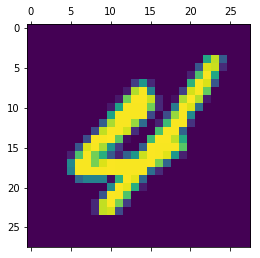

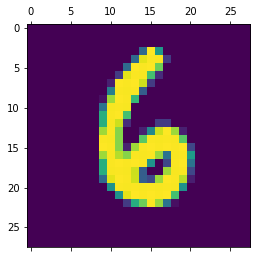

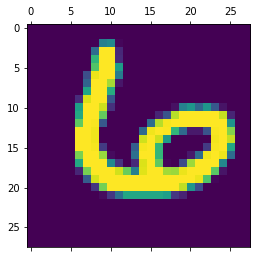

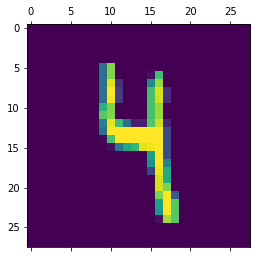

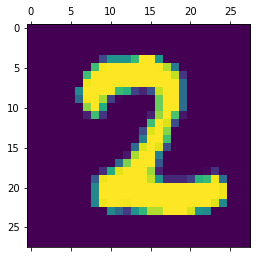

In [5]:
for i in range(5): 
    plt.matshow(test_set[i]['image'].squeeze())
    assert np.all(test_set[i]['image'].detach().numpy() <= 1)
    assert np.all(test_set[i]['image'].detach().numpy() >= 0)

In [6]:
slen = train_set_unlabeled[0]['image'].shape[0]

# Get data loaders

In [7]:
batchsize = 12

train_loader_labeled = torch.utils.data.DataLoader(
                 dataset=train_set_labeled,
                 batch_size=batchsize,
                 shuffle=True)

train_loader_unlabeled = torch.utils.data.DataLoader(
                 dataset=train_set_unlabeled,
                 batch_size=batchsize,
                 shuffle=True)

test_loader = torch.utils.data.DataLoader(
                dataset=test_set,
                batch_size=batchsize,
                shuffle=False)


In [8]:
for batch_idx, d in enumerate(train_loader_unlabeled):
    data_unlabeled = d
    break
    
for batch_idx, d in enumerate(train_loader_labeled):
    data_labeled = d
    break
    
for batch_idx, d in enumerate(test_loader):
    data_test = d
    break

In [9]:
data_unlabeled['image'].shape

torch.Size([12, 28, 28])

# Define VAE

In [10]:
latent_dim = 5
n_classes = 10

In [11]:
vae = mnist_vae_lib.HandwritingVAE(latent_dim = latent_dim, 
                                    n_classes = n_classes)

AttributeError: module 'mnist_vae_lib' has no attribute 'HandwritingVAE'

In [12]:
print(vae.parameters)

NameError: name 'vae' is not defined

In [13]:
28 * 28

784

In [14]:
2 * 28 * 28

1568

In [15]:
### Check things run

In [16]:
# check dimensions of encoder output

class_weights = vae.classifier(data_unlabeled['image'])
assert class_weights.shape[0] == batchsize
assert class_weights.shape[1] == n_classes 

latent_means, latent_std = \
    vae.encoder(data_unlabeled['image'], class_weights)
    
assert latent_means.shape[0] == batchsize
assert latent_means.shape[1] == latent_dim

assert latent_std.shape[0] == batchsize
assert latent_std.shape[1] == latent_dim


In [17]:
vae.get_semisupervised_loss(data_unlabeled['image'], train_set_unlabeled.num_images, 
                            labeled_images = data_labeled['image'], labels = data_labeled['label'],
                            alpha = 1.0, num_reinforced = 0)

(tensor(32386.7344), tensor(1.00000e+05 *
        3.6899), tensor(539.3008), tensor(541.7903), tensor(2.2917))

In [18]:
vae.get_semisupervised_loss(data_test['image'], test_loader.sampler.data_source.num_images, 
                            labeled_images = None, labels = None,
                            alpha = 1.0, num_reinforced = 0)

(tensor(5392.8848), tensor(53928.8438), tensor(539.2885), 0.0, 0.0)

In [19]:
class_weights = vae.classifier(data_unlabeled['image'])

In [20]:
cat_rv = Categorical(probs = class_weights)

In [21]:
n_samples = 10000
emp_probs = 0.0
for i in range(n_samples): 
    emp_probs += common_utils.get_one_hot_encoding_from_int(cat_rv.sample(), n_classes = 10)
    
emp_probs /= n_samples

In [22]:
torch.max(torch.abs(emp_probs - class_weights))

tensor(1.00000e-02 *
       1.0606)

# Check gradient works 

In [23]:
def get_vae_params(vae): 
    vae_params = np.array([])
    for f in vae.parameters(): 
        vae_params = np.append(vae_params, f.detach().numpy().flatten())
    return vae_params


In [24]:
vae_params0 = get_vae_params(vae)

In [25]:
assert np.any(np.isnan(vae_params0)) == False

In [26]:
optimizer = optim.Adam(vae.parameters(), lr=0.01)
optimizer.zero_grad()

In [27]:
num_unlabeled_total = train_loader_unlabeled.sampler.data_source.num_images

semi_super_loss, semi_super_ps_loss, \
            unlabeled_loss, labeled_loss, \
            cross_entropy_term = \
                vae.get_semisupervised_loss(data_unlabeled['image'],
                                            num_unlabeled_total,
                                            labeled_images = data_labeled['image'],
                                            labels = data_labeled['label'],
                                            alpha = 1.0,
                                            num_reinforced = 0)

In [28]:
semi_super_loss.backward()
optimizer.step()

In [29]:
vae_params1 = get_vae_params(vae)

In [30]:
assert np.any(np.isnan(vae_params1)) == False

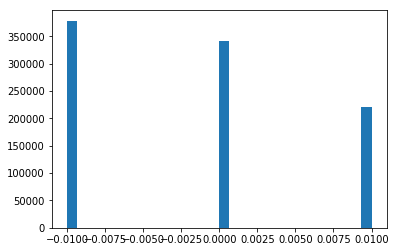

In [31]:
plt.hist(vae_params1 - vae_params0, bins = 30); 

In [32]:
semi_super_loss, semi_super_ps_loss, \
            unlabeled_loss, labeled_loss, \
            cross_entropy_term = \
                vae.get_semisupervised_loss(data_unlabeled['image'],
                                            num_unlabeled_total,
                                            labeled_images = data_labeled['image'],
                                            labels = data_labeled['label'],
                                            alpha = 1.0,
                                            num_reinforced = 0)

In [33]:
assert np.isfinite(semi_super_loss.detach().numpy())

In [34]:
train_loader_unlabeled.dataset.__len__()

54

In [35]:
mnist_vae_lib.train_semisupervised_model(vae, train_loader_unlabeled, 
                                        data_labeled['image'], 
                                        data_labeled['label'], 
                                        test_loader, 
                                        n_epoch = 5, print_every = 2, outfile = './test')

  * init train recon loss: 14280.92773;
  * init test recon loss: 13676.09961;
  * init train class accuracy: 0.07407;
  * init test class accuracy:  0.1;
[1] unlabeled_loss: 13977.95801  	[0.6 seconds]
[2] unlabeled_loss: 13652.2334  	[0.5 seconds]
  * train recon loss: 13319.00195;
  * test recon loss: 13927.2207;
  * train class accuracy: 0.07407;
  * test class accuracy:    0;
[3] unlabeled_loss: 13333.08398  	[0.5 seconds]
[4] unlabeled_loss: 12713.72656  	[0.5 seconds]
  * train recon loss: 13200.23926;
  * test recon loss: 12203.69336;
  * train class accuracy: 0.07407;
  * test class accuracy:    0;
[5] unlabeled_loss: 12938.66406  	[0.5 seconds]
writing the encoder parameters to ./test_enc_final

writing the decoder parameters to ./test_dec_final

writing the classifier parameters to ./test_classifier_final



In [36]:
classic_loss_array = np.loadtxt('./testloss_array.txt')

In [37]:
classic_loss_array

array([[0.00000000e+00, 2.00000000e+00, 4.00000000e+00],
       [1.42809277e+04, 1.33190020e+04, 1.32002393e+04],
       [1.36760996e+04, 1.39272207e+04, 1.22036934e+04],
       [7.40740746e-02, 7.40740746e-02, 7.40740746e-02],
       [1.00000001e-01, 0.00000000e+00, 0.00000000e+00]])